<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Credit Card Fraud Detection
# (Models based on standard data features)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Re-load-of-cleaned-data-from-CSV" data-toc-modified-id="Re-load-of-cleaned-data-from-CSV-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Re-load of cleaned data from CSV</a></span></li><li><span><a href="#Modelling-preparation" data-toc-modified-id="Modelling-preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modelling preparation</a></span><ul class="toc-item"><li><span><a href="#Dummy-categorical-variables" data-toc-modified-id="Dummy-categorical-variables-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Dummy categorical variables</a></span></li><li><span><a href="#Do-a-train/test-split" data-toc-modified-id="Do-a-train/test-split-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Do a train/test split</a></span></li><li><span><a href="#Deal-with-the-class-imbalance-in-the-training-set" data-toc-modified-id="Deal-with-the-class-imbalance-in-the-training-set-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Deal with the class imbalance in the training set</a></span></li><li><span><a href="#Heatmap-of-the-data-set" data-toc-modified-id="Heatmap-of-the-data-set-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Heatmap of the data set</a></span></li><li><span><a href="#Data-Standardisation" data-toc-modified-id="Data-Standardisation-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Data Standardisation</a></span></li></ul></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Definition-of-scoring-function" data-toc-modified-id="Definition-of-scoring-function-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Definition of scoring function</a></span></li><li><span><a href="#Creation-of-stratified-Kfold-for-use-in-cross-validation" data-toc-modified-id="Creation-of-stratified-Kfold-for-use-in-cross-validation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Creation of stratified Kfold for use in cross-validation</a></span></li><li><span><a href="#Basic-Logistic-Regression-Classifier" data-toc-modified-id="Basic-Logistic-Regression-Classifier-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Basic Logistic Regression Classifier</a></span></li><li><span><a href="#Decision-Tree-with-grid-search-for-best-parameters" data-toc-modified-id="Decision-Tree-with-grid-search-for-best-parameters-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Decision Tree with grid search for best parameters</a></span></li><li><span><a href="#Decision-Tree-with-Bagging-Classifier" data-toc-modified-id="Decision-Tree-with-Bagging-Classifier-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Decision Tree with Bagging Classifier</a></span></li><li><span><a href="#XGBoost-Classifier" data-toc-modified-id="XGBoost-Classifier-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>XGBoost Classifier</a></span></li></ul></li></ul></div>

In [1]:
from pprint import pprint
import numpy as np
import pandas as pd
import re
import time
import math
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime

## Re-load of cleaned data from CSV

In [2]:
tx_aug_df = pd.read_csv('~/GA/capstone2-data/augmented2_cc_txs.csv')

In [4]:
# ensure (after re-loading) that tx_date_time is in native datetime form
tx_aug_df.tx_date_time = pd.to_datetime( tx_aug_df.tx_date_time )

In [5]:
tx_aug_df.head()

,user_id,card,tx_year,tx_month,tx_day,tx_time,tx_amount,tx_use_chip,tx_merchant_name,tx_merchant_city,...,cc_card_number,cc_expires,cc_cvv,cc_has_chip,cc_cards_issued,cc_credit_limit,cc_acct_open_date,cc_year_pin_last_changed,cc_card_on_dark_web,tx_datetime_float
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,La Verne,...,4344676511950444,738490,623,1,2,24295.0,731094,2008,0,1.030858e+09
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,Monterey Park,...,4344676511950444,738490,623,1,2,24295.0,731094,2008,0,1.030859e+09
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,Monterey Park,...,4344676511950444,738490,623,1,2,24295.0,731094,2008,0,1.030944e+09
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,Monterey Park,...,4344676511950444,738490,623,1,2,24295.0,731094,2008,0,1.030985e+09
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,La Verne,...,4344676511950444,738490,623,1,2,24295.0,731094,2008,0,1.031031e+09


In [6]:
tx_aug_df.shape

(4465569, 52)

## Modelling preparation

In [13]:
retained_cols = ['user_id', 'card',
       'tx_amount', 'tx_use_chip',# 'tx_merchant_name',
       'tx_zip', 'tx_mcc','tx_is_fraud',
       'tx_hour', 'tx_fraud_error',
       'tx_abroad', 'tx_online', 'usr_current_age',
       'usr_retirement_age', 'usr_birth_year', 'usr_gender',
       'usr_zipcode',
       'usr_latitude', 'usr_longitude', 'usr_per_capita_income_zipcode',
       'usr_yearly_income_person', 'usr_total_debt', 'usr_fico_score',
       'usr_num_credit_cards', 'usr_apartment_set', 'cc_card_brand',
       'cc_card_type', 'cc_expires', 'cc_has_chip',
       'cc_cards_issued', 'cc_credit_limit', 'cc_acct_open_date',
       'cc_year_pin_last_changed', 'tx_datetime_float']

In [14]:
# create X with just the columns we'll use from here.
X = tx_aug_df[retained_cols].copy()

In [15]:
X.head()

,user_id,card,tx_amount,tx_use_chip,tx_zip,tx_mcc,tx_is_fraud,tx_hour,tx_fraud_error,tx_abroad,...,usr_apartment_set,cc_card_brand,cc_card_type,cc_expires,cc_has_chip,cc_cards_issued,cc_credit_limit,cc_acct_open_date,cc_year_pin_last_changed,tx_datetime_float
0,0,0,134.09,Swipe Transaction,91750.0,5300,0,6,0,0,...,0,Visa,Debit,738490,1,2,24295.0,731094,2008,1.030858e+09
1,0,0,38.48,Swipe Transaction,91754.0,5411,0,6,0,0,...,0,Visa,Debit,738490,1,2,24295.0,731094,2008,1.030859e+09
2,0,0,120.34,Swipe Transaction,91754.0,5411,0,6,0,0,...,0,Visa,Debit,738490,1,2,24295.0,731094,2008,1.030944e+09
3,0,0,128.95,Swipe Transaction,91754.0,5651,0,17,0,0,...,0,Visa,Debit,738490,1,2,24295.0,731094,2008,1.030985e+09
4,0,0,104.71,Swipe Transaction,91750.0,5912,0,6,0,0,...,0,Visa,Debit,738490,1,2,24295.0,731094,2008,1.031031e+09


### Dummy categorical variables

In [16]:
# Look at number of unique values for columns to check OK to dummy
X.nunique()

user_id                              373
card                                   9
tx_amount                          55007
tx_use_chip                            3
tx_zip                             19043
tx_mcc                               109
tx_is_fraud                            2
tx_hour                               24
tx_fraud_error                         2
tx_abroad                              2
tx_online                              2
usr_current_age                       70
usr_retirement_age                    24
usr_birth_year                        71
usr_gender                             2
usr_zipcode                          370
usr_latitude                         310
usr_longitude                        326
usr_per_capita_income_zipcode        367
usr_yearly_income_person             371
usr_total_debt                       358
usr_fico_score                       197
usr_num_credit_cards                   9
usr_apartment_set                      2
cc_card_brand   

In [17]:
# dummy other categorical variables.
dummy_cols = ['tx_use_chip','usr_gender','cc_card_brand','cc_card_type']

X_dummy = pd.get_dummies(X, columns=dummy_cols, drop_first=True)

In [18]:
X_dummy.head()

,user_id,card,tx_amount,tx_zip,tx_mcc,tx_is_fraud,tx_hour,tx_fraud_error,tx_abroad,tx_online,...,cc_year_pin_last_changed,tx_datetime_float,tx_use_chip_Online Transaction,tx_use_chip_Swipe Transaction,usr_gender_Male,cc_card_brand_Discover,cc_card_brand_Mastercard,cc_card_brand_Visa,cc_card_type_Debit,cc_card_type_Debit (Prepaid)
0,0,0,134.09,91750.0,5300,0,6,0,0,0,...,2008,1.030858e+09,0,1,0,0,0,1,1,0
1,0,0,38.48,91754.0,5411,0,6,0,0,0,...,2008,1.030859e+09,0,1,0,0,0,1,1,0
2,0,0,120.34,91754.0,5411,0,6,0,0,0,...,2008,1.030944e+09,0,1,0,0,0,1,1,0
3,0,0,128.95,91754.0,5651,0,17,0,0,0,...,2008,1.030985e+09,0,1,0,0,0,1,1,0
4,0,0,104.71,91750.0,5912,0,6,0,0,0,...,2008,1.031031e+09,0,1,0,0,0,1,1,0


### Do a train/test split

In [19]:
# first split off the target
y = X_dummy.pop('tx_is_fraud')

In [20]:
# Stratify using target variable

X_train, X_test, y_train, y_test = train_test_split( X_dummy, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

In [21]:
print("X_train ", X_train.shape)
print("X_test", X_test.shape)
print("y_train ", y_train.shape)
print("y_test", y_test.shape)

X_train  (3572455, 36)
X_test (893114, 36)
y_train  (3572455,)
y_test (893114,)


In [22]:
# check target numbers too
print("Fraud samples in Train:", y_train.value_counts().loc[1] )
print("Fraud samples in Test:", y_test.value_counts().loc[1])

Fraud samples in Train: 4000
Fraud samples in Test: 1000


### Deal with the class imbalance in the training set

In [23]:
# undersample the majority class to create a 1:1 class balance
from imblearn.under_sampling import RandomUnderSampler

us = RandomUnderSampler(random_state=42,sampling_strategy=1.0)
X_train_rs, y_train_rs = us.fit_resample(X_train, y_train)

In [24]:
# examine the shape
X_train_rs.shape

(8000, 36)

In [25]:
# check we have a 50/50 class balance now.
y_train_rs.value_counts()

0    4000
1    4000
Name: tx_is_fraud, dtype: int64

### Heatmap of the data set

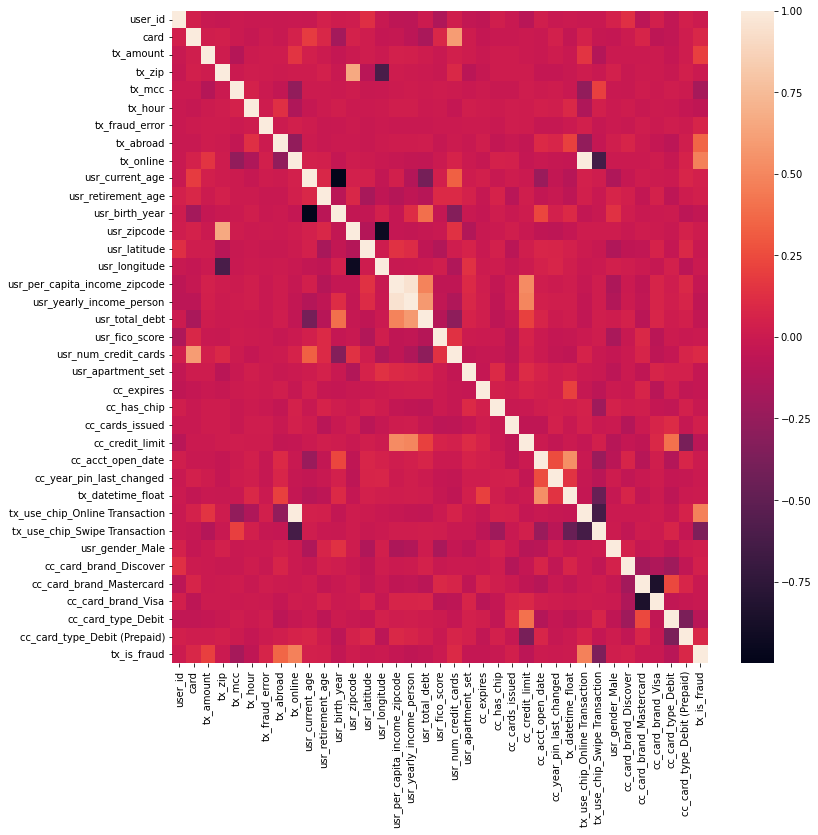

In [26]:
# Create X_temp and attach y variable "tx_is_fraud" to use for plotting heatmap()
X_temp = X_train_rs.copy()
X_temp['tx_is_fraud'] = y_train_rs
fig=plt.figure(figsize=(12,12))
sns.heatmap(X_temp.corr())
plt.show()

In [27]:
# a look at correlation coefficients in textural form
corr_df = pd.DataFrame(X_temp.corr().loc['tx_is_fraud'].reset_index())
corr_df.rename( columns={'index':'feature','tx_is_fraud':'correlation'}, inplace=True)
corr_df.drop( index=corr_df[corr_df.feature == 'tx_is_fraud'].index, inplace=True)
corr_df['abs_correlation'] = np.abs(corr_df.correlation)
corr_df.sort_values(by='abs_correlation', ascending=False)

,feature,correlation,abs_correlation
28,tx_use_chip_Online Transaction,0.474678,0.474678
8,tx_online,0.474074,0.474074
29,tx_use_chip_Swipe Transaction,-0.365509,0.365509
7,tx_abroad,0.352450,0.352450
2,tx_amount,0.195901,0.195901
4,tx_mcc,-0.178647,0.178647
19,usr_num_credit_cards,0.099318,0.099318
34,cc_card_type_Debit,-0.091072,0.091072
1,card,0.085505,0.085505
35,cc_card_type_Debit (Prepaid),0.082320,0.082320


# Modelling

### Data Standardisation
Standardise the predictor data for use with models

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Note X_train_rs is used here, with the scaled version being assigned to X_train
X_train = pd.DataFrame(scaler.fit_transform(X_train_rs), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [29]:
# also (for simplicity) assign y_train to the re-sampled y training set, y_train_rs
y_train = y_train_rs

In [30]:
# check X_train is standardised
X_train.describe()

,user_id,card,tx_amount,tx_zip,tx_mcc,tx_hour,tx_fraud_error,tx_abroad,tx_online,usr_current_age,...,cc_year_pin_last_changed,tx_datetime_float,tx_use_chip_Online Transaction,tx_use_chip_Swipe Transaction,usr_gender_Male,cc_card_brand_Discover,cc_card_brand_Mastercard,cc_card_brand_Visa,cc_card_type_Debit,cc_card_type_Debit (Prepaid)
count,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,...,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03
mean,4.440892e-19,9.887646e-16,-7.180367e-17,2.720046e-17,4.521036e-16,3.494011e-16,5.646518e-15,-1.054697e-14,2.218700e-14,-5.852957e-17,...,-2.195169e-14,5.025841e-16,1.089698e-14,-5.078382e-15,-8.665291e-17,1.175789e-15,-9.123813e-16,-2.590705e-16,-1.024320e-15,-5.434750e-15
std,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,...,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00
min,-1.686590e+00,-9.776269e-01,-3.460176e+00,-2.544278e+00,-3.972041e+00,-2.646258e+00,-1.810832e-01,-3.723277e-01,-7.311805e-01,-2.243056e+00,...,-2.827869e+00,-3.281292e+00,-7.307780e-01,-8.745488e-01,-9.838799e-01,-1.732014e-01,-1.110861e+00,-7.663560e-01,-1.205814e+00,-3.074752e-01
25%,-8.566834e-01,-9.776269e-01,-3.920588e-01,-2.642346e-01,-3.372441e-01,-6.833002e-01,-1.810832e-01,-3.723277e-01,-7.311805e-01,-7.586073e-01,...,-7.536375e-01,-7.796434e-01,-7.307780e-01,-8.745488e-01,-9.838799e-01,-1.732014e-01,-1.110861e+00,-7.663560e-01,-1.205814e+00,-3.074752e-01
50%,1.052186e-02,-2.942704e-01,-2.015780e-01,1.208844e-02,3.350207e-03,-2.898089e-02,-1.810832e-01,-3.723277e-01,-7.311805e-01,-1.400871e-01,...,-6.222695e-02,8.390461e-02,-7.307780e-01,-8.745488e-01,-9.838799e-01,-1.732014e-01,9.002024e-01,-7.663560e-01,8.293152e-01,-3.074752e-01
75%,8.777271e-01,3.890861e-01,1.367566e-01,1.208844e-02,4.341967e-01,6.253384e-01,-1.810832e-01,-3.723277e-01,1.367651e+00,5.402851e-01,...,6.291836e-01,8.117289e-01,1.368405e+00,1.143447e+00,1.016384e+00,-1.732014e-01,9.002024e-01,1.304877e+00,8.293152e-01,-3.074752e-01
max,1.782232e+00,3.805869e+00,2.213167e+01,2.227892e+00,4.291401e+00,2.370190e+00,5.522324e+00,2.685806e+00,1.367651e+00,2.890662e+00,...,3.049121e+00,1.578204e+00,1.368405e+00,1.143447e+00,1.016384e+00,5.773627e+00,9.002024e-01,1.304877e+00,8.293152e-01,3.252295e+00


## Modelling

### Definition of scoring function
This function will be used to asssess the performance of the models on both the training and test sets throughout the rest of the notebook.

In [31]:
# definition of function to be used to evaluate classifier.
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

def report_classification_scores(model, X_train, y_train, X_test, y_test, title_text ):
    """Function to report performance of training and test data via Classification reports
    and confusion matrix"""
    y_pred_train=model.predict(X_train)    
    y_pred_test=model.predict(X_test)

    print("\n")
    fig, ax = plt.subplots( nrows=2, ncols=2, figsize=(15, 15) )

    title = f'Results for {title_text}'
    fig.suptitle( title, fontsize=20 )
    
    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, cmap='Blues', ax=ax[0][0])
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Reds', ax=ax[0][1])
    RocCurveDisplay.from_estimator(model, X_train, y_train, ax=ax[1][0])
    ax[1][0].plot([0, 1], [0, 1], 'k--', linewidth=4)
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[1][1])
    ax[1][1].plot([0, 1], [0, 1], 'k--', linewidth=4)
    
    ax[0][0].set_title('Confusion matrix for training data') 
    ax[0][1].set_title('Confusion matrix for test data') 
    ax[1][0].set_title('ROC curve for training data') 
    ax[1][1].set_title('ROC curve for test data') 
    plt.show()

    print("Classification report for training set:")
    print(classification_report(y_train, y_pred_train, digits=4))
    print("Classification report for test set:")
    print(classification_report(y_test, y_pred_test, digits=4))

### Creation of stratified Kfold for use in cross-validation

In [32]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold( n_splits=5, shuffle=True, random_state=1 )

### Basic Logistic Regression Classifier

In [33]:
from sklearn.linear_model import LogisticRegressionCV
lg_cv_model = LogisticRegressionCV(penalty='elasticnet', solver='saga', #verbose=1,
                                   n_jobs=-1, l1_ratios=np.linspace(0,1,10), max_iter=10000, cv=skf)
lg_cv_model.fit(X_train, y_train)
best_l1_ratio = lg_cv_model.l1_ratio_
best_C = lg_cv_model.C_
print( "Best C: ", best_C, "\nBest l1_ratio: ", best_l1_ratio)

Best C:  [0.00599484] 
Best l1_ratio:  [0.]


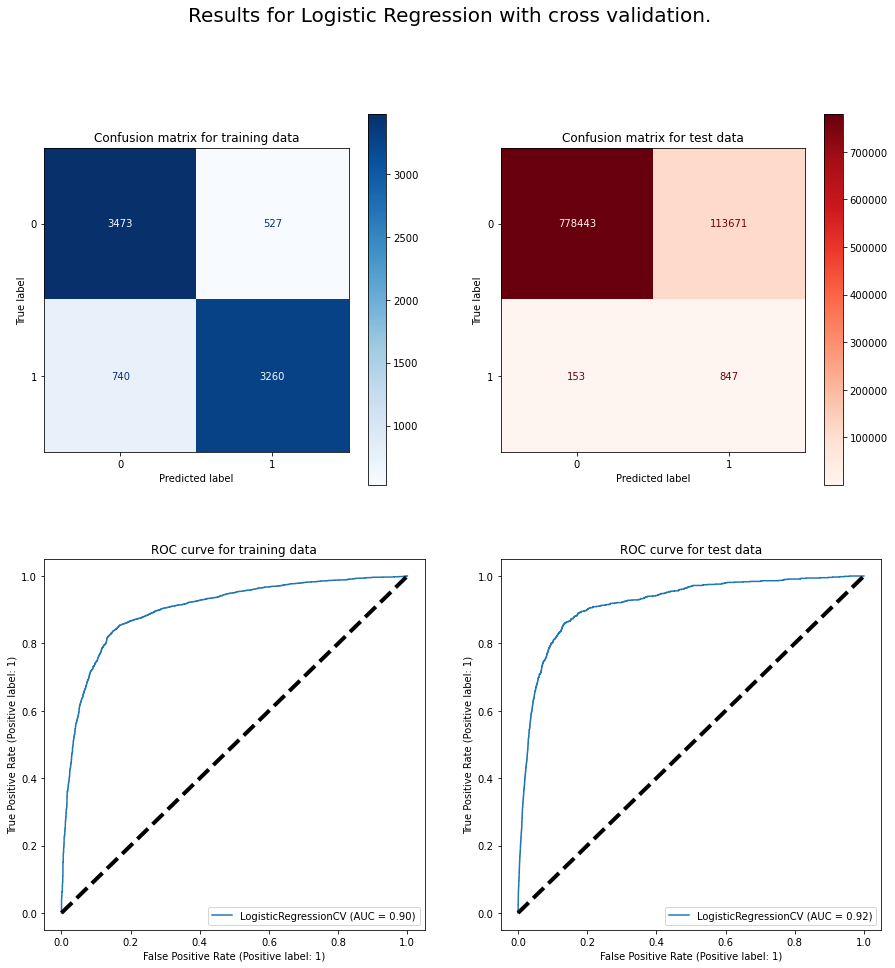

Classification report for training set:
              precision    recall  f1-score   support

           0     0.8244    0.8682    0.8457      4000
           1     0.8608    0.8150    0.8373      4000

    accuracy                         0.8416      8000
   macro avg     0.8426    0.8416    0.8415      8000
weighted avg     0.8426    0.8416    0.8415      8000

Classification report for test set:
              precision    recall  f1-score   support

           0     0.9998    0.8726    0.9319    892114
           1     0.0074    0.8470    0.0147      1000

    accuracy                         0.8726    893114
   macro avg     0.5036    0.8598    0.4733    893114
weighted avg     0.9987    0.8726    0.9308    893114



In [407]:
report_classification_scores(lg_cv_model, X_train, y_train, X_test, y_test, "Logistic Regression with cross validation." )

In [408]:
# let's see what the coefficients looked like
coeff_df = pd.DataFrame( data=list(zip(X_train.columns, lg_cv_model.coef_[0])), columns=['feature','coefficient'] )
coeff_df['abs_coefficient'] = np.abs(coeff_df.coefficient)
coeff_df.sort_values(by='abs_coefficient', ascending=False).head(10)

,feature,coefficient,abs_coefficient
7,tx_abroad,1.233145,1.233145
28,tx_use_chip_Online Transaction,0.629120,0.629120
8,tx_online,0.617473,0.617473
2,tx_amount,0.415092,0.415092
27,tx_datetime_float,-0.221174,0.221174
6,tx_fraud_error,0.136440,0.136440
16,usr_yearly_income_person,-0.127180,0.127180
1,card,0.113705,0.113705
19,usr_num_credit_cards,0.108792,0.108792
5,tx_hour,-0.102749,0.102749


### Decision Tree with grid search for best parameters

In [409]:
# Let's see if we can find some better parameters for our decision tree via grid search
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
gs_dtc_model = DecisionTreeClassifier(random_state=42)

parameters = {'criterion':['gini','entropy'],
             'splitter':['random','best'],
             'max_depth':[None,5,10,15,20],
             'min_samples_split':[2,4,8,16,32],
             'min_samples_leaf':[1,2,4,8,16,32],
             'max_features':[0.2,0.4,0.6,0.8,1.0],
             'max_leaf_nodes':[None,100,50,25,12,6]}

# NOTE scoring set for PRECISION!
gs_model = GridSearchCV( gs_dtc_model, parameters, verbose=4, n_jobs=-1, scoring='roc_auc')
gs_model.fit(X_train, y_train) # commented out so not to re-run.  Takes a few hours!

Fitting 5 folds for each of 18000 candidates, totalling 90000 fits


GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15, 20],
                         'max_features': [0.2, 0.4, 0.6, 0.8, 1.0],
                         'max_leaf_nodes': [None, 100, 50, 25, 12, 6],
                         'min_samples_leaf': [1, 2, 4, 8, 16, 32],
                         'min_samples_split': [2, 4, 8, 16, 32],
                         'splitter': ['random', 'best']},
             scoring='roc_auc', verbose=4)

In [155]:
gs_model.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': 50,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'splitter': 'best'}

In [156]:
# look at the individual CV scores.
index = gs_model.best_index_

for i in range(0,5):
    split_name = f'split{i}_test_score'
    score = gs_model.cv_results_[split_name][index]
    print( f'cv: {i} score: {score}')
    
print( "overall mean: ", gs_model.cv_results_['mean_test_score'][index] )

cv: 0 score: 0.9700304687500001
cv: 1 score: 0.9692007812499999
cv: 2 score: 0.9688320312500002
cv: 3 score: 0.9601046875
cv: 4 score: 0.9654546875
overall mean:  0.96672453125


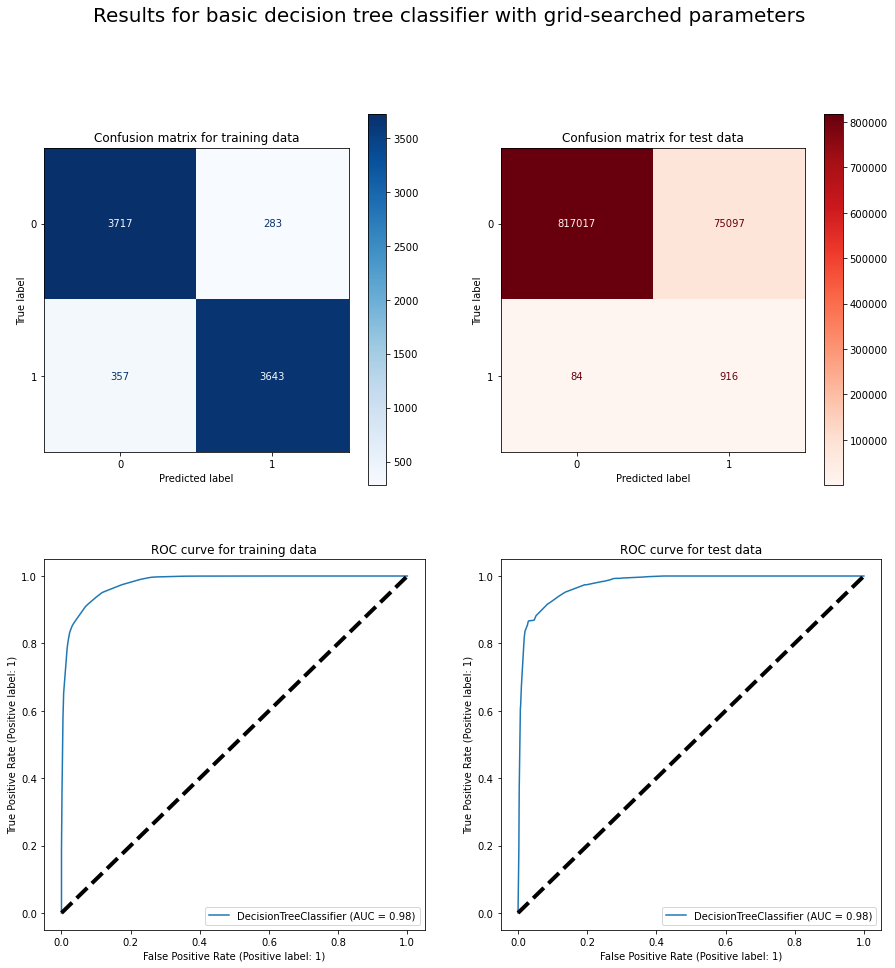

Classification report for training set:
              precision    recall  f1-score   support

           0     0.9124    0.9293    0.9207      4000
           1     0.9279    0.9107    0.9193      4000

    accuracy                         0.9200      8000
   macro avg     0.9201    0.9200    0.9200      8000
weighted avg     0.9201    0.9200    0.9200      8000

Classification report for test set:
              precision    recall  f1-score   support

           0     0.9999    0.9158    0.9560    892114
           1     0.0121    0.9160    0.0238      1000

    accuracy                         0.9158    893114
   macro avg     0.5060    0.9159    0.4899    893114
weighted avg     0.9988    0.9158    0.9550    893114



In [157]:
report_classification_scores(gs_model.best_estimator_, X_train, y_train, X_test, y_test, "basic decision tree classifier with grid-searched parameters" )

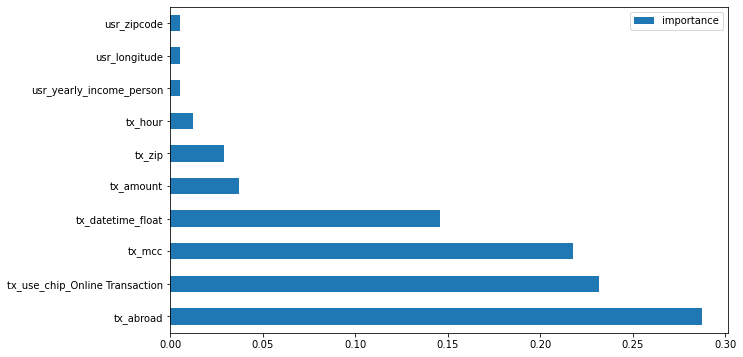

In [160]:
# Let's take a look at the top feature importances.
pd.DataFrame(gs_model.best_estimator_.feature_importances_, columns=['importance'], index=X_train.columns).sort_values(
                        by='importance', ascending=False).head(10).plot(kind='barh', figsize=(10, 6));

### Decision Tree with Bagging Classifier

In [276]:
from sklearn.ensemble import BaggingClassifier

bag_dtc_model=DecisionTreeClassifier(random_state=42)

bag_classifier=BaggingClassifier(bag_dtc_model, 
                                 n_estimators=50, 
                                 max_samples=0.8,
                                 max_features=0.8,
                                 random_state=1, 
                                 n_jobs=-1,
                                verbose=2)
bag_classifier.fit(X_train, y_train)

print("model fit done.")

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


model fit done.


[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.5s remaining:   15.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.5s finished


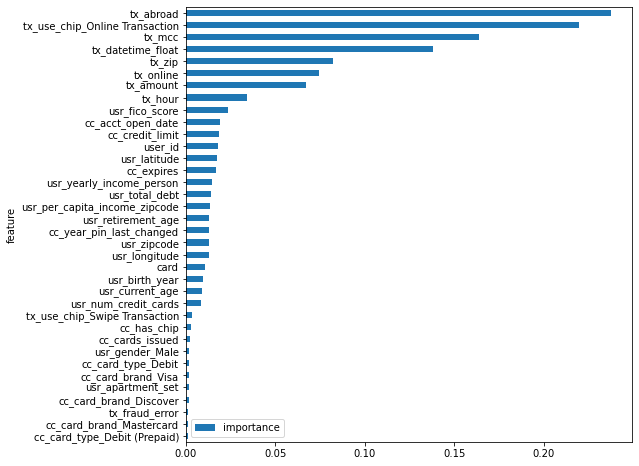

In [440]:
# Calculation of feature importances, averaging across the estimators in the ensemble.
num_features=X_train.shape[1]
num_classifiers=bag_classifier.n_estimators

# create a dictionary of the features
feature_dict = {}

for feature_no in range(0, num_features):
    dict_entry = {}
    dict_entry['name'] = X_train.columns[feature_no] # useful for debug
    dict_entry['importances'] = [] # create a blank list of importances initially.
    feature_dict[feature_no] = dict_entry

# populate the dictionary from the importances in the
# estimators and the list of feature numbers stored in the bagger
for est_no, estimator in enumerate(bag_classifier.estimators_):
    for imp_no, importance in enumerate(estimator.feature_importances_):
        feature_no = bag_classifier.estimators_features_[est_no][imp_no]
#        print( f'estimator {est_no}, feature {feature_no}, importance {importance}' )
        feature_dict[feature_no]['importances'].append(importance)

# calculate the average importance for each feature.
avg_importances = []
for feature_no in feature_dict.keys():
    avg_importance = np.mean(feature_dict[feature_no]['importances'])
#    print( "feature ", feature_dict[feature_no]['name'], " importance ", avg_importance )
    avg_importances.append(avg_importance)

# stort the feature importances in a data frame.
features_df = pd.DataFrame( data=list(zip(X_train.columns, avg_importances)), columns=['feature','importance'] )

# plot data frame.
features_df.sort_values(by='importance').plot(kind='barh', x='feature', figsize=(8,8));

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   17.6s remaining:   29.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.2s remaining:   15.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   10.1s finished


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    8.3s remaining:   14.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.7s finished


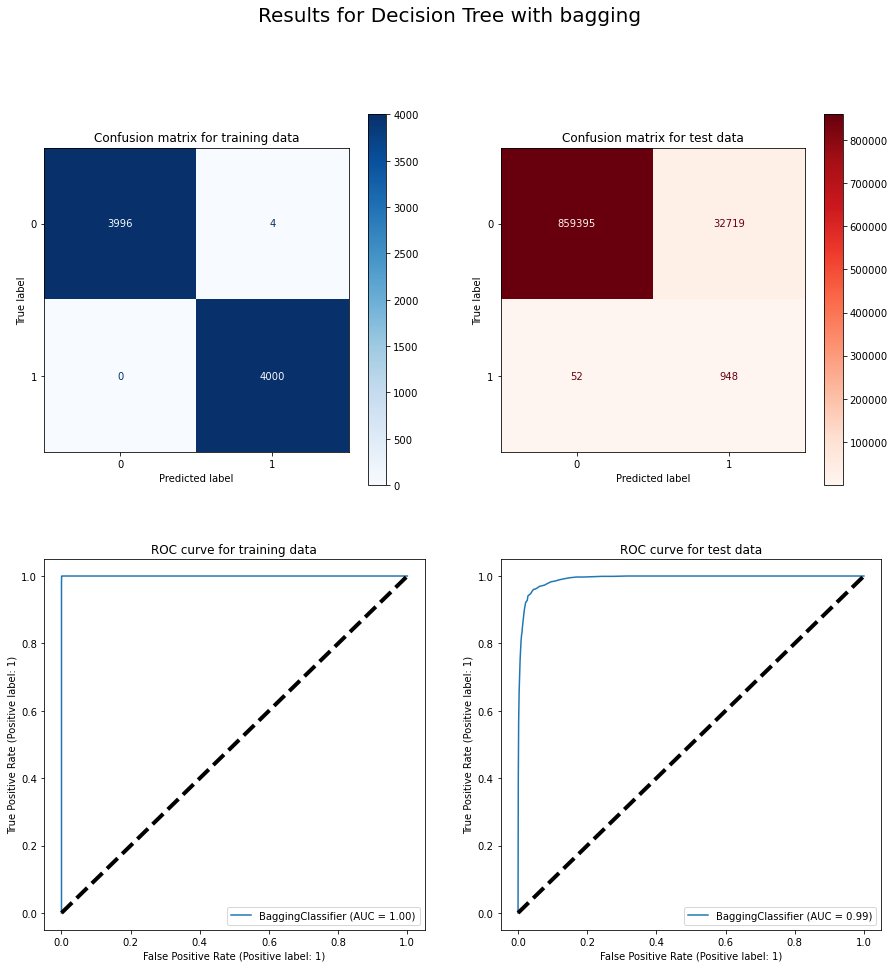

Classification report for training set:
              precision    recall  f1-score   support

           0     1.0000    0.9990    0.9995      4000
           1     0.9990    1.0000    0.9995      4000

    accuracy                         0.9995      8000
   macro avg     0.9995    0.9995    0.9995      8000
weighted avg     0.9995    0.9995    0.9995      8000

Classification report for test set:
              precision    recall  f1-score   support

           0     0.9999    0.9633    0.9813    892114
           1     0.0282    0.9480    0.0547      1000

    accuracy                         0.9633    893114
   macro avg     0.5140    0.9557    0.5180    893114
weighted avg     0.9989    0.9633    0.9803    893114



In [441]:
report_classification_scores(bag_classifier, X_train, y_train, X_test, y_test, "Decision Tree with bagging" )

### XGBoost Classifier

In [442]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(disable_default_eval_metric=True,
                          random_state=42,
                          n_estimators=500, 
                          n_jobs=-1, 
                          learning_rate=0.1, 
                          early_stopping_rounds=10, 
                          eval_metric='auc' )
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.96695
[1]	validation_0-auc:0.96685
[2]	validation_0-auc:0.97157
[3]	validation_0-auc:0.97175
[4]	validation_0-auc:0.97240
[5]	validation_0-auc:0.97331
[6]	validation_0-auc:0.97359
[7]	validation_0-auc:0.97555
[8]	validation_0-auc:0.97602
[9]	validation_0-auc:0.97694
[10]	validation_0-auc:0.97735
[11]	validation_0-auc:0.97738
[12]	validation_0-auc:0.97752
[13]	validation_0-auc:0.97794
[14]	validation_0-auc:0.97831
[15]	validation_0-auc:0.97898
[16]	validation_0-auc:0.97916
[17]	validation_0-auc:0.98188
[18]	validation_0-auc:0.98331
[19]	validation_0-auc:0.98425
[20]	validation_0-auc:0.98477
[21]	validation_0-auc:0.98530
[22]	validation_0-auc:0.98562
[23]	validation_0-auc:0.98602
[24]	validation_0-auc:0.98630
[25]	validation_0-auc:0.98660
[26]	validation_0-auc:0.98693
[27]	validation_0-auc:0.98716
[28]	validation_0-auc:0.98734
[29]	validation_0-auc:0.98759
[30]	validation_0-auc:0.98789
[31]	validation_0-auc:0.98835
[32]	validation_0-auc:0.98841
[33]	validation_0-au

[268]	validation_0-auc:0.99535
[269]	validation_0-auc:0.99534
[270]	validation_0-auc:0.99535
[271]	validation_0-auc:0.99535
[272]	validation_0-auc:0.99536
[273]	validation_0-auc:0.99537
[274]	validation_0-auc:0.99539
[275]	validation_0-auc:0.99538
[276]	validation_0-auc:0.99539
[277]	validation_0-auc:0.99539
[278]	validation_0-auc:0.99539
[279]	validation_0-auc:0.99540
[280]	validation_0-auc:0.99539
[281]	validation_0-auc:0.99539
[282]	validation_0-auc:0.99540
[283]	validation_0-auc:0.99540
[284]	validation_0-auc:0.99539
[285]	validation_0-auc:0.99541
[286]	validation_0-auc:0.99540
[287]	validation_0-auc:0.99539
[288]	validation_0-auc:0.99540
[289]	validation_0-auc:0.99540
[290]	validation_0-auc:0.99540
[291]	validation_0-auc:0.99541
[292]	validation_0-auc:0.99539
[293]	validation_0-auc:0.99539
[294]	validation_0-auc:0.99539
[295]	validation_0-auc:0.99541
[296]	validation_0-auc:0.99541
[297]	validation_0-auc:0.99541
[298]	validation_0-auc:0.99541
[299]	validation_0-auc:0.99542
[300]	va

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              disable_default_eval_metric=True, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, ...)

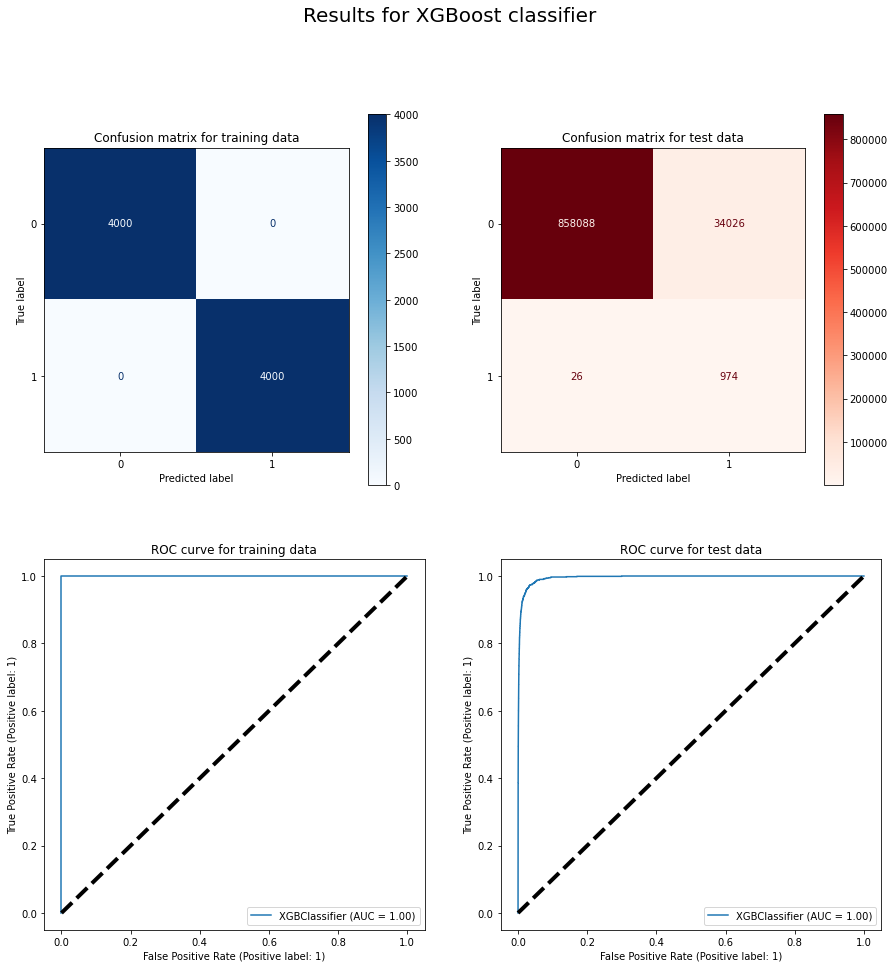

Classification report for training set:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      4000
           1     1.0000    1.0000    1.0000      4000

    accuracy                         1.0000      8000
   macro avg     1.0000    1.0000    1.0000      8000
weighted avg     1.0000    1.0000    1.0000      8000

Classification report for test set:
              precision    recall  f1-score   support

           0     1.0000    0.9619    0.9805    892114
           1     0.0278    0.9740    0.0541      1000

    accuracy                         0.9619    893114
   macro avg     0.5139    0.9679    0.5173    893114
weighted avg     0.9989    0.9619    0.9795    893114



In [443]:
report_classification_scores(xgb_model, X_train, y_train, X_test, y_test, "XGBoost classifier" )

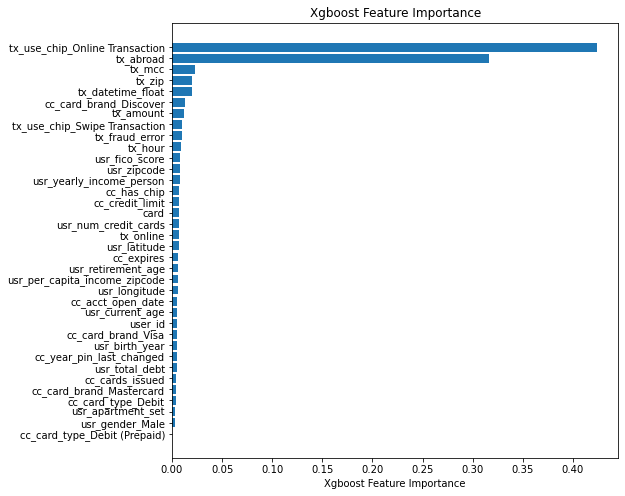

In [446]:
plt.figure(figsize=(8,8))
sorted_idx = xgb_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Xgboost Feature Importance")
plt.show()